<a href="https://colab.research.google.com/github/wellingtonwcps/Tutoriais/blob/master/Relatorio_IPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
!pip install fpdf

In [268]:
! pip install -U kaleido

Requirement already up-to-date: kaleido in /usr/local/lib/python3.7/dist-packages (0.2.1)


In [269]:
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

/usr/local/bin/orca: Text file busy
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgtk2.0-0 is already the newest version (2.24.32-1ubuntu1).
libgconf-2-4 is already the newest version (3.2.6-4ubuntu1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


# Importação das Bibliotecas

In [270]:
import os
import shutil
import numpy as np
import pandas as pd
import calendar
from datetime import datetime
from fpdf import FPDF
from datetime import datetime, date, time

import kaleido
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('seaborn-bright')
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [271]:
PLOT_DIR = 'plots'
try:
        shutil.rmtree(PLOT_DIR)
        os.mkdir(PLOT_DIR)
except:
        FileNotFoundError
        os.mkdir(PLOT_DIR)

# Preparação dos Dados para gerar os Gráficos

In [272]:
## Carregamento e análise dos dados

ipo_2021 = pd.read_excel('IPO_09_04.xlsx')
ipo_2021.head()

,Lotação,Ano,IPO Unidade,Efetivo,Mandados de Busca,Meta Mandados de Busca,Descaptalização,Meta Descaptalização,Apreensão ePol,Meta Apreensão ePol,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares
0,SR/PF/AC,2021,8.11756,206,95,164.8,25628195.00,204229340,802244.95,12681520,17,16.48,3,10.30,15,57.68,25,59.74
1,SR/PF/AP,2021,7.56003,159,33,127.2,21335.75,157633326,1136019.00,9788163,4,12.72,7,7.95,4,44.52,15,46.11
2,SR/PF/PA,2021,7.48109,436,30,348.8,2395336.00,432252389,82059752.00,26840497,10,34.88,6,21.80,19,122.08,16,126.44
3,SR/PF/ES,2021,7.47738,304,34,243.2,11102102.90,301386987,7907986.01,18714475,9,24.32,4,15.20,10,85.12,7,88.16
4,SR/PF/RO,2021,7.36102,321,44,256.8,610626.40,318240864,4722542.00,19761008,14,25.68,2,16.05,21,89.88,11,93.09


In [273]:
ipo_2020 = pd.read_excel('legado_mj_06_04_2021.xlsx')
ipo_2020 = ipo_2020[ipo_2020['ano_deflagracao'] == 2020]
ipo_2020.head()

,sg_uf,nm_operacao,dt_deflagracao,sg_unidade,competencia,tipo,nr_outras_med_cautelares,nr_mba,vlr_apreendido,nr_mpp,nr_mpt,nr_serv_pub_preso,nr_flagrante,dt_inicio,dia_deflagracao,mes_deflagracao,ano_deflagracao,competencia2
17686,SP,FLAGRANTE 287/2019-DPF/SJK/SP,2020-01-01,PF/SJK/SP,DDH,SIMPLES,0,0,0.0,0,0,0,0,2019-09-03,1,1,2020,DDH
17687,TO,OPERAÇÃO FORA DO CAIXA,2020-01-09,SR/PF/TO,DASP,APOIO,0,0,0.0,0,0,0,0,2020-01-09,9,1,2020,DASP
17688,RJ,MPP LINDA MARA DA SILVA,2020-01-13,PF/GOY/RJ,DASP,SIMPLES,0,0,0.0,1,0,0,0,2020-01-13,13,1,2020,DASP
17689,RS,DIOGO DA ROSA BALTAZAR,2020-01-16,NIP/SR/PF/RS,DDH,COMUM,0,0,0.0,1,0,0,0,2019-11-13,16,1,2020,DDH
17690,AL,APOIO A OPERAÇÃO ROOSEVELT,2020-01-18,SR/PF/AL,DDH,APOIO,0,0,0.0,0,0,0,0,2020-01-18,18,1,2020,DDH


In [274]:
## Seleciona os dados de 2020 até o mês corrente de 2021
mes_corrente = 3 # mes_corrente representa o mês até o qual se quer o relatório
relatorio_2020 = ipo_2020[ipo_2020['mes_deflagracao'] <= mes_corrente]


Preparar o dataset para Gerar o gráfico

In [275]:
relatorio_2021 = ipo_2021.drop(['IPO Unidade', 'Efetivo'], axis=1)
relatorio_2021['ano_deflagracao'] = relatorio_2021['Ano']
relatorio_2021 = relatorio_2021.drop('Ano', axis = 1)


In [276]:
relatorio_2020 = relatorio_2020.drop(['competencia2','competencia', 'nr_outras_med_cautelares',\
                                      'nr_serv_pub_preso', 'dt_inicio',	'dia_deflagracao'], axis = 1) 

In [277]:
relatorio_2020 = relatorio_2020.rename(columns={'nr_mba':'Mandados de Busca',	'vlr_apreendido':'Descapitalização',	'nr_mpp':'Prisões Preventivas',\
                                                'nr_mpt':	'Prisões Temporárias', 	'nr_flagrante':'Prisões Flagrante'})

In [278]:
relatorio_2020['Prisões Cautelares'] = relatorio_2020['Prisões Preventivas'] + relatorio_2020['Prisões Temporárias'] 


In [279]:
relatorio_2020 = relatorio_2020.drop(['Prisões Preventivas', 'Prisões Temporárias' ], axis = 1) 

In [280]:
relatorio_2021.head()

,Lotação,Mandados de Busca,Meta Mandados de Busca,Descaptalização,Meta Descaptalização,Apreensão ePol,Meta Apreensão ePol,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares,ano_deflagracao
0,SR/PF/AC,95,164.8,25628195.00,204229340,802244.95,12681520,17,16.48,3,10.30,15,57.68,25,59.74,2021
1,SR/PF/AP,33,127.2,21335.75,157633326,1136019.00,9788163,4,12.72,7,7.95,4,44.52,15,46.11,2021
2,SR/PF/PA,30,348.8,2395336.00,432252389,82059752.00,26840497,10,34.88,6,21.80,19,122.08,16,126.44,2021
3,SR/PF/ES,34,243.2,11102102.90,301386987,7907986.01,18714475,9,24.32,4,15.20,10,85.12,7,88.16,2021
4,SR/PF/RO,44,256.8,610626.40,318240864,4722542.00,19761008,14,25.68,2,16.05,21,89.88,11,93.09,2021


In [281]:
def UF (x):
  y = x[-2:]
  return y

In [282]:
relatorio_2021['sg_uf'] = relatorio_2021['Lotação'].apply(UF)

In [283]:
relatorio_2021 = relatorio_2021.drop('Lotação', axis = 1)

In [284]:
relatorio_2021 = relatorio_2021.drop(['Apreensão ePol','Meta Apreensão ePol'], axis = 1)

In [285]:
relatorio_2020 = relatorio_2020.drop(['mes_deflagracao','nm_operacao', 'sg_unidade','dt_deflagracao'], axis = 1)

In [286]:
relatorio_2020.head()

,sg_uf,tipo,Mandados de Busca,Descapitalização,Prisões Flagrante,ano_deflagracao,Prisões Cautelares
17686,SP,SIMPLES,0,0.0,0,2020,0
17687,TO,APOIO,0,0.0,0,2020,0
17688,RJ,SIMPLES,0,0.0,0,2020,1
17689,RS,COMUM,0,0.0,0,2020,1
17690,AL,APOIO,0,0.0,0,2020,0


In [287]:
relatorio_2020_teste = relatorio_2020.groupby(by=['tipo','sg_uf']).count().reset_index()
relatorio_2020_teste.head()

,tipo,sg_uf,Mandados de Busca,Descapitalização,Prisões Flagrante,ano_deflagracao,Prisões Cautelares
0,APOIO,AC,11,11,11,11,11
1,APOIO,AL,5,5,5,5,5
2,APOIO,AM,1,1,1,1,1
3,APOIO,AP,6,6,6,6,6
4,APOIO,BA,10,10,10,10,10


In [288]:
comuns = relatorio_2020_teste[relatorio_2020_teste['tipo']=='COMUM']
comuns= comuns.drop(['tipo',	'Mandados de Busca',	'Descapitalização',	'Prisões Flagrante',	'ano_deflagracao'], axis = 1)
comuns= comuns.rename(columns={'Prisões Cautelares':'Op. Comuns'})
comuns.head()


,sg_uf,Op. Comuns
25,AC,2
26,AM,1
27,AP,2
28,BA,2
29,CE,5


In [289]:
especiais = relatorio_2020_teste[relatorio_2020_teste['tipo']=='ESPECIAL']
especiais= especiais.drop(['tipo',	'Mandados de Busca',	'Descapitalização',	'Prisões Flagrante',	'ano_deflagracao'], axis = 1)
especiais= especiais.rename(columns={'Prisões Cautelares':'Op. Especiais'})
especiais.head()

,sg_uf,Op. Especiais
48,AC,3
49,AM,1
50,AP,3
51,BA,4
52,CE,2


In [290]:
relatorio_2020 = relatorio_2020_teste = relatorio_2020.groupby(by='sg_uf').sum().reset_index()
relatorio_2020['ano_deflagracao'] = 2020
relatorio_2020.head()

,sg_uf,Mandados de Busca,Descapitalização,Prisões Flagrante,ano_deflagracao,Prisões Cautelares
0,AC,57,3950574.70,60,2020,7
1,AL,0,920.00,5,2020,0
2,AM,3,23822470.01,47,2020,0
3,AP,13,38000000.00,3,2020,7
4,BA,30,469800.00,3,2020,10


In [291]:
relatorio_2020 = pd.merge(relatorio_2020, comuns, how='left', on='sg_uf')
relatorio_2020['Op. Comuns'] = relatorio_2020['Op. Comuns'].fillna(value = 0)
relatorio_2020['Op. Comuns'] = relatorio_2020['Op. Comuns'].astype(int)
relatorio_2020.head()

,sg_uf,Mandados de Busca,Descapitalização,Prisões Flagrante,ano_deflagracao,Prisões Cautelares,Op. Comuns
0,AC,57,3950574.70,60,2020,7,2
1,AL,0,920.00,5,2020,0,0
2,AM,3,23822470.01,47,2020,0,1
3,AP,13,38000000.00,3,2020,7,2
4,BA,30,469800.00,3,2020,10,2


In [292]:
relatorio_2020 = pd.merge(relatorio_2020, especiais, how='left', on='sg_uf')
relatorio_2020['Op. Especiais'] = relatorio_2020['Op. Especiais'].fillna(value = 0)
relatorio_2020['Op. Especiais'] = relatorio_2020['Op. Especiais'].astype(int)
relatorio_2020.head()

,sg_uf,Mandados de Busca,Descapitalização,Prisões Flagrante,ano_deflagracao,Prisões Cautelares,Op. Comuns,Op. Especiais
0,AC,57,3950574.70,60,2020,7,2,3
1,AL,0,920.00,5,2020,0,0,0
2,AM,3,23822470.01,47,2020,0,1,1
3,AP,13,38000000.00,3,2020,7,2,3
4,BA,30,469800.00,3,2020,10,2,4


In [293]:
relatorio_2021.head()

,Mandados de Busca,Meta Mandados de Busca,Descaptalização,Meta Descaptalização,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares,ano_deflagracao,sg_uf
0,95,164.8,25628195.00,204229340,17,16.48,3,10.30,15,57.68,25,59.74,2021,AC
1,33,127.2,21335.75,157633326,4,12.72,7,7.95,4,44.52,15,46.11,2021,AP
2,30,348.8,2395336.00,432252389,10,34.88,6,21.80,19,122.08,16,126.44,2021,PA
3,34,243.2,11102102.90,301386987,9,24.32,4,15.20,10,85.12,7,88.16,2021,ES
4,44,256.8,610626.40,318240864,14,25.68,2,16.05,21,89.88,11,93.09,2021,RO


In [294]:
relatorio_2021 = relatorio_2021.rename(columns={'Descaptalização':'Descapitalização'})


In [295]:
dados_para_grafico_comparacao = relatorio_2021.drop(['Meta Mandados de Busca',	'Meta Descaptalização',	'Meta Op. Especiais',	'Meta Op. Comuns',\
                                                     'Meta Prisões Flagrante',	'Meta Prisões Cautelares'], axis =1)
dados_para_grafico_comparacao.head()

,Mandados de Busca,Descapitalização,Op. Especiais,Op. Comuns,Prisões Flagrante,Prisões Cautelares,ano_deflagracao,sg_uf
0,95,25628195.00,17,3,15,25,2021,AC
1,33,21335.75,4,7,4,15,2021,AP
2,30,2395336.00,10,6,19,16,2021,PA
3,34,11102102.90,9,4,10,7,2021,ES
4,44,610626.40,14,2,21,11,2021,RO


In [296]:
dados_para_grafico_comparacao  = pd.concat([dados_para_grafico_comparacao, relatorio_2020]).reset_index()
filtro = dados_para_grafico_comparacao['sg_uf']!='PF'
dados_para_grafico_comparacao = dados_para_grafico_comparacao[filtro]
dados_para_grafico_comparacao.head()

,index,Mandados de Busca,Descapitalização,Op. Especiais,Op. Comuns,Prisões Flagrante,Prisões Cautelares,ano_deflagracao,sg_uf
0,0,95,25628195.00,17,3,15,25,2021,AC
1,1,33,21335.75,4,7,4,15,2021,AP
2,2,30,2395336.00,10,6,19,16,2021,PA
3,3,34,11102102.90,9,4,10,7,2021,ES
4,4,44,610626.40,14,2,21,11,2021,RO


In [297]:
dados_para_grafico_comparacao = dados_para_grafico_comparacao.groupby(by='ano_deflagracao').sum().reset_index()
dados_para_grafico_comparacao['ano_deflagracao'] = dados_para_grafico_comparacao['ano_deflagracao'].astype('str')
dados_para_grafico_comparacao = dados_para_grafico_comparacao.rename(columns={'ano_deflagracao':'Ano'})
dados_para_grafico_comparacao.head()

,Ano,index,Mandados de Busca,Descapitalização,Op. Especiais,Op. Comuns,Prisões Flagrante,Prisões Cautelares
0,2020,351,949,1.113955e+09,78,88,1420,431
1,2021,393,1110,4.084359e+08,171,93,350,427


In [298]:
dados_para_grafico_comparacao['Ano'] = dados_para_grafico_comparacao['Ano'].astype('str')

In [299]:
relatorio_2021.head()

,Mandados de Busca,Meta Mandados de Busca,Descapitalização,Meta Descaptalização,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares,ano_deflagracao,sg_uf
0,95,164.8,25628195.00,204229340,17,16.48,3,10.30,15,57.68,25,59.74,2021,AC
1,33,127.2,21335.75,157633326,4,12.72,7,7.95,4,44.52,15,46.11,2021,AP
2,30,348.8,2395336.00,432252389,10,34.88,6,21.80,19,122.08,16,126.44,2021,PA
3,34,243.2,11102102.90,301386987,9,24.32,4,15.20,10,85.12,7,88.16,2021,ES
4,44,256.8,610626.40,318240864,14,25.68,2,16.05,21,89.88,11,93.09,2021,RO


#Gerar os gráficos

*   Item da lista
*   Item da lista



In [300]:
fig = px.bar(dados_para_grafico_comparacao, dados_para_grafico_comparacao['Ano'], dados_para_grafico_comparacao['Mandados de Busca'])
fig.update_layout(title = 'Comparativo Resultados 2020 x 2021 - ')
fig.update_layout(xaxis=dict(type='category'))
fig.show()

In [301]:
def comparacao(coluna, nome:str):
  fig = px.bar(dados_para_grafico_comparacao, dados_para_grafico_comparacao['Ano'], coluna)
  fig.update_layout(title = 'Comparativo Resultados 2020 x 2021 - '+nome)
  fig.update_layout(xaxis=dict(type='category'))
  plotly.io.write_image(fig, 'plots/'+nome+'.jpg')
  return fig


In [302]:
comparacao(dados_para_grafico_comparacao['Mandados de Busca'], 'Mandados de Busca e Apreensão Março')

In [303]:
dados_para_grafico_comparacao.columns

Index(['Ano', 'index', 'Mandados de Busca', 'Descapitalização',
       'Op. Especiais', 'Op. Comuns', 'Prisões Flagrante',
       'Prisões Cautelares'],
      dtype='object')

In [304]:
comparacao(dados_para_grafico_comparacao['Descapitalização'], 'Descapitalização Março')

In [305]:
comparacao(dados_para_grafico_comparacao['Op. Especiais'], 'Op. Especiais Março')

In [306]:
comparacao(dados_para_grafico_comparacao['Op. Comuns'], 'Op. Comuns Março')

In [307]:
comparacao(dados_para_grafico_comparacao['Prisões Flagrante'], 'Prisões Flagrante Março')

In [308]:
comparacao(dados_para_grafico_comparacao['Prisões Cautelares'], 'Prisões Cautelares Março')

## Cria o gráfico da meta

In [309]:
relatorio_2021.head()

,Mandados de Busca,Meta Mandados de Busca,Descapitalização,Meta Descaptalização,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares,ano_deflagracao,sg_uf
0,95,164.8,25628195.00,204229340,17,16.48,3,10.30,15,57.68,25,59.74,2021,AC
1,33,127.2,21335.75,157633326,4,12.72,7,7.95,4,44.52,15,46.11,2021,AP
2,30,348.8,2395336.00,432252389,10,34.88,6,21.80,19,122.08,16,126.44,2021,PA
3,34,243.2,11102102.90,301386987,9,24.32,4,15.20,10,85.12,7,88.16,2021,ES
4,44,256.8,610626.40,318240864,14,25.68,2,16.05,21,89.88,11,93.09,2021,RO


In [310]:
filtro = relatorio_2021['sg_uf']!='PF' ## Exclui a linha com o valor Global da PF
relatorio_2021 = relatorio_2021[filtro]
relatorio_2021.head()

,Mandados de Busca,Meta Mandados de Busca,Descapitalização,Meta Descaptalização,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares,ano_deflagracao,sg_uf
0,95,164.8,25628195.00,204229340,17,16.48,3,10.30,15,57.68,25,59.74,2021,AC
1,33,127.2,21335.75,157633326,4,12.72,7,7.95,4,44.52,15,46.11,2021,AP
2,30,348.8,2395336.00,432252389,10,34.88,6,21.80,19,122.08,16,126.44,2021,PA
3,34,243.2,11102102.90,301386987,9,24.32,4,15.20,10,85.12,7,88.16,2021,ES
4,44,256.8,610626.40,318240864,14,25.68,2,16.05,21,89.88,11,93.09,2021,RO


In [311]:
relatorio_2021= relatorio_2021.groupby(by='ano_deflagracao').sum().reset_index()
relatorio_2021.head()

,ano_deflagracao,Mandados de Busca,Meta Mandados de Busca,Descapitalização,Meta Descaptalização,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares
0,2021,1110,9783.2,4.084359e+08,12123886378,171,978.32,93,611.45,350,3424.12,427,3546.41


In [312]:
relatorio_2021

,ano_deflagracao,Mandados de Busca,Meta Mandados de Busca,Descapitalização,Meta Descaptalização,Op. Especiais,Meta Op. Especiais,Op. Comuns,Meta Op. Comuns,Prisões Flagrante,Meta Prisões Flagrante,Prisões Cautelares,Meta Prisões Cautelares
0,2021,1110,9783.2,4.084359e+08,12123886378,171,978.32,93,611.45,350,3424.12,427,3546.41


In [329]:
def meta_desempenho(coluna, coluna_meta, nome_arquivo, indicador):
  
  ''' Função para gerar  o gráfico de comparação entre a meta e o resultado
  coluna: coluna de Pandas DataFrame com o desempenho
  coluna_meta: coluna de Pandas DataFrame com a meta
  nome_arquivo:str com o nome do aqrquivo gerado
  indicador: str com o nome do Indicador'''

  
  plt.bar(0, coluna, width=barWidth)
  plt.bar (0.25, coluna_meta, width=barWidth)
  plt.title ('Resultado x Meta '+indicador)
  plt.xticks ([-0.05,0.25],['Desempenho', 'Meta'])
  plt.savefig('plots/'+nome_arquivo+'.jpg', dpi=300)
  return plt.show()

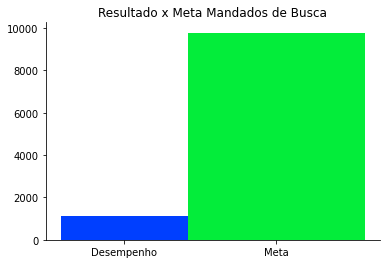

In [315]:
meta_desempenho(relatorio_2021['Mandados de Busca'], relatorio_2021['Meta Mandados de Busca'], 'Mandados_de_Busca', 'Mandados de Busca')

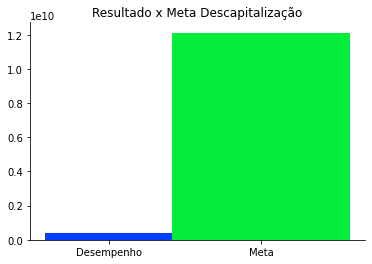

In [316]:
meta_desempenho(relatorio_2021['Descapitalização'], relatorio_2021['Meta Descaptalização'], 'descapitalizacao', 'Descapitalização')

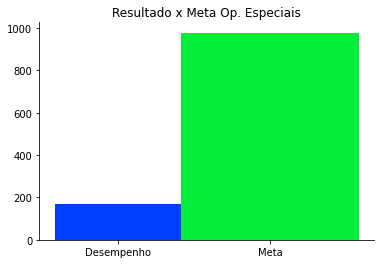

In [317]:
meta_desempenho(relatorio_2021['Op. Especiais'], relatorio_2021['Meta Op. Especiais'], 'Op_Especiais', 'Op. Especiais')

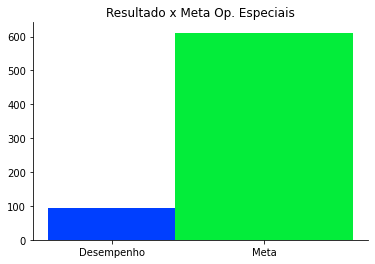

In [318]:
meta_desempenho(relatorio_2021['Op. Comuns'], relatorio_2021['Meta Op. Comuns'], 'Op_Comuns', 'Op. Especiais')

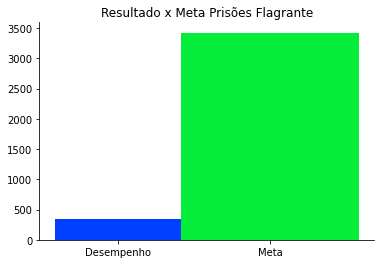

In [319]:
meta_desempenho(relatorio_2021['Prisões Flagrante'], relatorio_2021['Meta Prisões Flagrante'], 'Prisões_Flagrante', 'Prisões Flagrante')

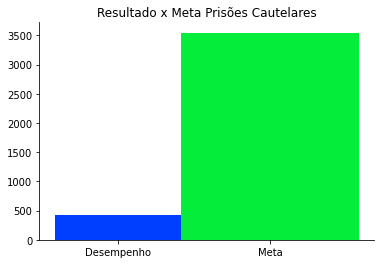

In [320]:
meta_desempenho(relatorio_2021['Prisões Cautelares'], relatorio_2021['Meta Prisões Cautelares'], 'Prisões_Cautelares', 'Prisões Cautelares')

# Criando os Relatórios

In [321]:
def construct():
        
    # Construct data shown in document
    counter = 0
    pages_data = []
    temp = []
    # Get all plots
    files = os.listdir(PLOT_DIR)

    # Iterate over all created visualization
    for fname in files:
        # We want 3 per page
        if counter == 2:
            pages_data.append(temp)
            temp = []
            counter = 0

        temp.append(f'{PLOT_DIR}/{fname}')
        counter += 1

    return [*pages_data, temp]

In [322]:
plots_per_page = construct()
plots_per_page

[['plots/Op_Comuns.jpg', 'plots/Prisões_Cautelares.jpg'],
 ['plots/Op. Especiais Março.jpg', 'plots/descapitalizacao.jpg'],
 ['plots/Prisões_Flagrante.jpg', 'plots/Op_Especiais.jpg'],
 ['plots/Descapitalização Março.jpg',
  'plots/Mandados de Busca e Apreensão Março.jpg'],
 ['plots/Prisões Cautelares Março.jpg', 'plots/Prisões Flagrante Março.jpg'],
 ['plots/Mandados_de_Busca.jpg', 'plots/Op. Comuns Março.jpg']]

In [327]:
class PDF(FPDF):
    def __init__(self):
        super().__init__()
        self.WIDTH = 210
        self.HEIGHT = 297
        
    def header(self):
        # Cabeçalho
        self.set_font('Arial', 'B', 11)
        self.cell(self.WIDTH - 80)
        self.cell(60, 1, 'CGE/PF - RELATÓRIO IPO', 0, 0, 'R')
        self.ln(20)
        
    def footer(self):
        # Page numbers in the footer
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.set_text_color(128)
        self.cell(0, 10, 'Coordenação de Gestão Estratégica/PF - Página ' + str(self.page_no()), 0, 0, 'C')

    def page_body(self, images):
        # Determine how many plots there are per page and set positions
        # and margins accordingly
        if len(images) == 3:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 5, self.WIDTH - 30)
            self.image(images[2], 15, self.WIDTH / 2 + 90, self.WIDTH - 30)
        elif len(images) == 2:
            self.image(images[0], 15, 30, self.WIDTH - 30)
            self.image(images[1], 15, self.WIDTH / 2 + 45, self.WIDTH - 30)
        else:
            self.image(images[0], 15, 25, self.WIDTH - 30)
            
    def print_page(self, images):
        # Generates the report
        self.add_page()
        self.page_body(images)

In [326]:
pdf = PDF()

for elem in plots_per_page:
    pdf.print_page(elem)
    
pdf.output('Relatorio_IPO.pdf', 'F')

''